# Домашнее задание (10 баллов)


(2 балла)
1. закончить реализацию `ClassificationDecisionTree` в decision_tree
    1. реализовать feature_importance_ (для этого метода теста нет, подойдет реализацию любого варианта, базовый способ - рекурсивно суммировать по всем `self.feature_id` `self.q_value_max` и вывести суммы. 
    2. проверить корректность predict 
2. реализовать `BaseSampler`, `ObjectSampler` и `FeatureSampler`. `BaseSampler` - базовый класс, у которого должен быть реализован метода `sample_indices` - вернуть индексы сэмплов. `ObjectSampler` сэплирует объекты, `FeatureSampler` - признаки.
3. реализовать `RandomForestClassifier` в random_forest (predict/predict_proba).

Обратите внимение, что в random_forest в качестве `base_estimator` предполагается использовать `DecisionTreeClassifier` из sklearn, использовать вашу реализацию решающего дерева необязательно. <br> Пример запуска тестов 
- `python -m unittest discover sem_dt_rf/decision_tree/tests`
- `python -m unittest discover sem_dt_rf/random_forest/tests` 

Или через `pytest`
- `python -m pytest sem_dt_rf/decision_tree/tests/test_criterio.py`

(1 балл) Для регрессионного дерева необходимо использовать такой критерий:
$$H(R) = \min_c \frac{1}{|R|} \sum_{(x_i, y_i) \in R} (y_i - c)^2$$

Докажите, что минимум H(R) достигается при $c$:


$$ c = \frac{1}{|R|} \sum_{(x_j, y_j) \in R} y_j$$

Решение: Это задача минимизации без оганицений, значит можно построить лагранжиан(это и есть сама целевая функция), условия стационарности выполнено, а дополняющей нежесткости и неотрицательности просто нет, так как нет и условий оптимизации. Тогда можно просто дифференцировать по с и приравнивать к 0, выраженая с и будет ответом. 
$$\frac{d \sum_{(x_i, y_i) \in R} (y_i - c)^2}{|R| dc} = \frac{-2}{|R|} \sum_{(x_i, y_i) \in R}( y_i - c ) = 0$$

Сократим константу

$$ \sum_{(x_i, y_i) \in R} y_i - \sum_{(x_i, y_i) \in R} c = \sum_{(x_i, y_i) \in R}y_i -|R|c = 0$$

Тогда:

$$c = \frac{1}{|R|} \sum_{(x_i, y_i) \in R} y_i$$

(3 балла) Реализуйте регрессионное дерево. В качестве критерия необходимо использовать критерий, определённый в пункте 2, в коде есть заглушка `MSECriterion`. В качестве `predict` необходимо использовать среднее значение ответов по всем объектам в листе. В коде нет готовой заглушки, реализуйте по аналогии с `class ClassificationDecisionTree(DecisionTree):`.

Сгенерируйте однопризнаковую выборку для тестирования дерева и покажите работу дерева на этой выборке (пример см. ниже, можно использовать свою версию). Отобразите на одном графике `predict` алгоритма и значение признака. Что меняется при изменении параметра глубины? Сделайте выводы.

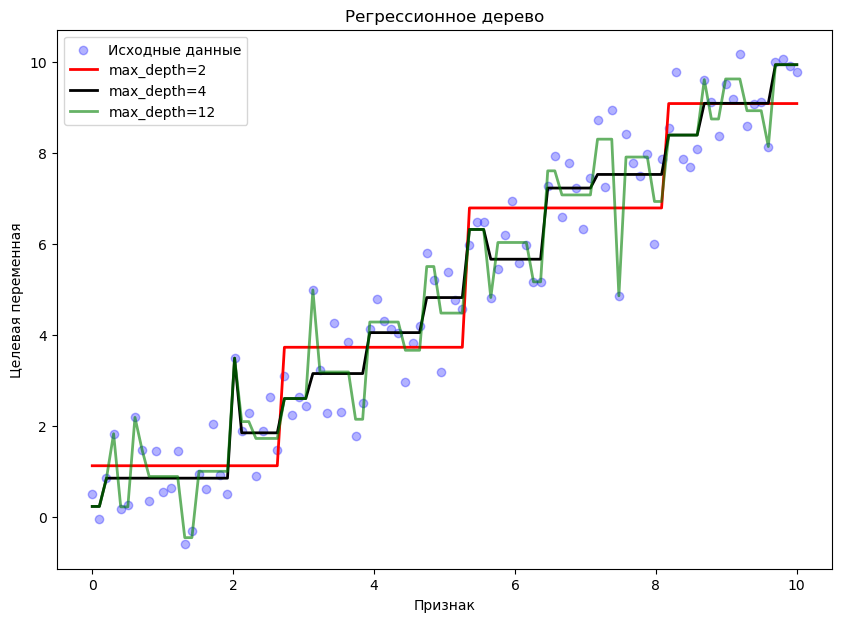

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sem_dt_rf.decision_tree.decision_tree import RegressionDecisionTree

np.random.seed(42)
n = 100
X = np.linspace(0, 10, n)
y = X + np.random.normal(0, 1, n)

X = X.reshape(-1, 1)

tree_2 = RegressionDecisionTree(max_depth=2)
tree_2.fit(X, y)
y_pred_2 = tree_2.predict(X)

tree_4 = RegressionDecisionTree(max_depth=4)
tree_4.fit(X, y)
y_pred_4 = tree_4.predict(X)

tree_12 = RegressionDecisionTree(max_depth=12)
tree_12.fit(X, y)
y_pred_12 = tree_12.predict(X)


plt.figure(figsize=(10, 7))
plt.scatter(X, y, label="Исходные данные", color="blue", alpha=0.3)

plt.plot(X, y_pred_2, label="max_depth=2", color="red", linewidth=2)
plt.plot(X, y_pred_4, label="max_depth=4", color="black", linewidth=2)
plt.plot(X, y_pred_12, label="max_depth=12", color="green", linewidth=2, alpha=0.6)
6
plt.xlabel("Признак")
plt.ylabel("Целевая переменная")
plt.legend()
plt.title("Регрессионное дерево")
plt.show()


Можно побаловаться с глубиной дерева и внезапно окажется, что дерево склонно переобучатся, зеленый график сильно навязчивый так что я его сделал полупрозрачным. Кажется что значения глубины 3-4 адекватные. При значениях 1-2 все примитивно: 1 это просто ступенька, а 2 это две ступеньки. Грубина 4 все еще ступеньки, но при этом кое где черный график достает отдельные значения, как например на х=2(что плохо), в то же время есть выступ гдето на х=5.75, там график потянулся к нескольким значениям(это уже хорошо, он предсказает тренд а не переобучается). Зеленый это жесть, естественно он тянется ко всем точкам и в итоге ошибка на тесте будет большой. 

Но не будем разглагольствовать и все проверим

In [62]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

np.random.seed(42)
n_ = 100
X = np.linspace(0, 20, n_)
y = X + np.random.normal(0, 1, n_)

X = X.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

depths = [1, 2, 3, 4, 5, 6, 8, 10, 12, 100]
for d in depths:
    tree = RegressionDecisionTree(max_depth=d)
    tree.fit(X_train, y_train)

    y_train_pred = tree.predict(X_train)
    y_test_pred = tree.predict(X_test)

    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)

    print(f"Depth={d}: Train MSE={train_error:.2f}, Test MSE={test_error:.2f}")


Depth=1: Train MSE=8.97, Test MSE=7.74
Depth=2: Train MSE=2.41, Test MSE=2.99
Depth=3: Train MSE=0.81, Test MSE=1.23
Depth=4: Train MSE=0.48, Test MSE=0.86
Depth=5: Train MSE=0.45, Test MSE=0.87
Depth=6: Train MSE=0.42, Test MSE=0.98
Depth=8: Train MSE=0.38, Test MSE=1.04
Depth=10: Train MSE=0.38, Test MSE=1.04
Depth=12: Train MSE=0.38, Test MSE=1.04
Depth=100: Train MSE=0.38, Test MSE=1.04


Видно что при малых глубинах ошибка на тесте здоровая, оно и понятно. Минимум достигается на d=4, а дальше начинается переобучение которое достикает своего пика на d=8.

Теперь тест посложнее:

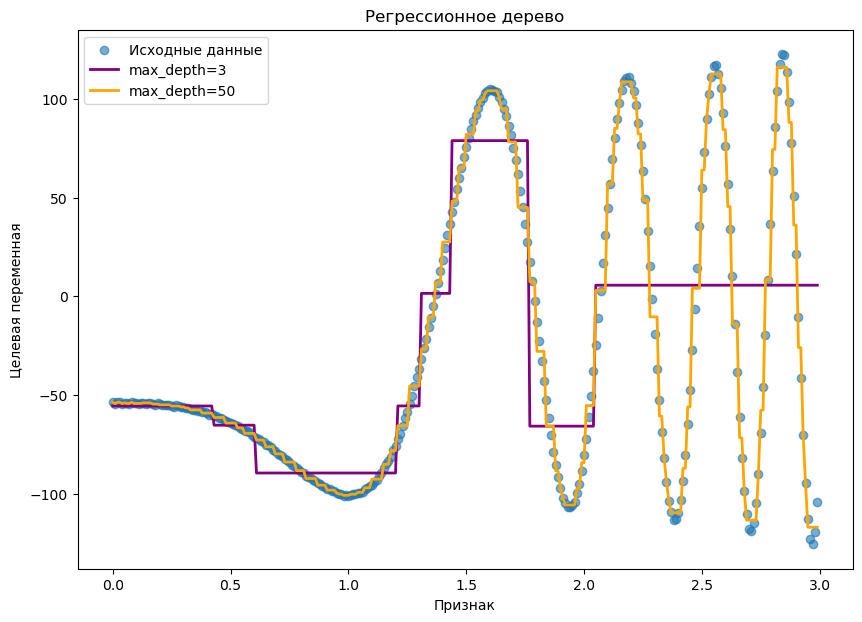

In [106]:
# generate example
x_shape = 300
x = np.arange(x_shape) / 100
y = (x**3 + 100) * np.sin(x**3 + 10) + np.random.random(x_shape)

x = x.reshape(-1, 1)

tree_3 = RegressionDecisionTree(max_depth=3)
tree_3.fit(x, y)
y_pred_3 = tree_3.predict(x)

tree_50 = RegressionDecisionTree(max_depth=50)
tree_50.fit(x, y)
y_pred_50 = tree_50.predict(x)



plt.figure(figsize=(10, 7))
plt.scatter(x, y, label="Исходные данные", alpha=0.6)

plt.plot(x, y_pred_3, label="max_depth=3", color="purple", linewidth=2)
plt.plot(x, y_pred_50, label="max_depth=50", color="orange", linewidth=2)


plt.xlabel("Признак")
plt.ylabel("Целевая переменная")
plt.legend()
plt.title("Регрессионное дерево")
plt.show()

In [107]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.33, random_state=42)

depths = [1, 3, 5, 6, 8, 10, 13, 16, 20, 25, 30, 40, 50]
for d in depths:
    tree = RegressionDecisionTree(max_depth=d)
    tree.fit(X_train, y_train)

    y_train_pred = tree.predict(X_train)
    y_test_pred = tree.predict(X_test)

    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)

    print(f"Depth={d}: Train MSE={train_error:.2f}, Test MSE={test_error:.2f}")

Depth=1: Train MSE=3633.37, Test MSE=3384.91
Depth=3: Train MSE=2463.79, Test MSE=2199.18
Depth=5: Train MSE=1512.26, Test MSE=1797.51
Depth=6: Train MSE=479.07, Test MSE=599.69
Depth=8: Train MSE=108.37, Test MSE=226.97
Depth=10: Train MSE=87.63, Test MSE=206.65
Depth=13: Train MSE=83.64, Test MSE=207.86
Depth=16: Train MSE=83.64, Test MSE=207.86
Depth=20: Train MSE=83.64, Test MSE=207.86
Depth=25: Train MSE=83.64, Test MSE=207.86
Depth=30: Train MSE=83.64, Test MSE=207.86
Depth=40: Train MSE=83.64, Test MSE=207.86
Depth=50: Train MSE=83.64, Test MSE=207.86


Оптимальное значение глубины от 10 и выше. Если ставить меньше то график не может обрабоать хвост, а если больше то он начинает захватывать самые верхние и самые нижние точки и при этом на данной задаче не переобучается. 

In [41]:
from sem_dt_rf.decision_tree.tests.test_tree_node import TestTreeNode
from sem_dt_rf.decision_tree.tests.test_decision_tree import TestDecisionTree, TestRegressionTree
from sem_dt_rf.decision_tree.tests.test_criterio import TestGiniCriterion, TestEntropyCriterion, TestMSECriterion

test1 = TestTreeNode()
test1.test_get_best_split()

test2 = TestDecisionTree()
test2.test_small_decision_tree()
test2.test_decision_tree()

test3 = TestRegressionTree()
test3.test_small_regression_tree()
test3.test_regression_tree()
test3.test_feature_importance()

test4 = TestGiniCriterion()
test4.test_gini_get_predict_val()
test4.test_gini_score()
test4.test_gini_get_best_split()
test4.test_gini_get_best_split_2()

test5 = TestEntropyCriterion()
test5.test_entropy_get_predict_val()
test5.test_entropy_score()
test5.test_entropy_get_best_split()
test5.test_entropy_get_best_split_v2()

test6 = TestMSECriterion()
test6.test_mse_get_predict_val()
test6.test_mse_score()
test6.test_mse_get_best_split()
test6.test_mse_get_best_split_v2()

c:\Users\Admin\OneDrive\Рабочий стол\AIM 2сем\ML2\hw1\sem_dt_rf\decision_tree\criterio.py:72: RuntimeWarning: invalid value encountered in divide
  return np.bincount(target, minlength=self.n_classes) / target.shape[0]
c:\Users\Admin\OneDrive\Рабочий стол\AIM 2сем\ML2\hw1\sem_dt_rf\decision_tree\criterio.py:87: RuntimeWarning: invalid value encountered in divide
  return np.bincount(target, minlength=self.n_classes) / target.shape[0]


(4 балла) Протестируйте различные реализации `random_forest` на `fetch_covtype` датасете (можно загрузить с помощью `sklearn.datasets.fetch_covtype`). Возможно, поможет ноутбук с семинара `ensembles_seminar.ipynb`. Для честного сравнения старайтесь использовать похожий набор гиперпараметров.
- ваша реализация (import `RandomForestClassifier as MyRandomForestClassifier` ниже)
- sklearn https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- lightgbm https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMModel.html см. параметр `boosting_type`
- xgboost https://xgboost.readthedocs.io/en/stable/tutorials/rf.html

    Что нужно сделать: 
- Разбейте данные на train и test. 
- Оцените качество алгоритмов по метрике (balanced_accuracy_score)[https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html]
- Оцените время работы `train` и `predict`
- Сделайте выводы

In [3]:
import sys
sys.path.extend(['C://Users//Admin//OneDrive//Рабочий стол//AIM 2сем//ML2//hw1'])

from sem_dt_rf.random_forest.random_forest import RandomForestClassifier as MyRandomForestClassifier

In [ ]:
#!pip install lightgbm
#!pip install xgboost

In [4]:
from sklearn.datasets import fetch_covtype
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import xgboost as xgb

In [5]:
cov_type = fetch_covtype()

X = cov_type.data
y = cov_type.target
y = y-1

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

X_train.shape, X_test.shape

((389278, 54), (191734, 54))

In [136]:
my_rf = MyRandomForestClassifier(n_estimators = 50, max_depth=40)
my_rf.fit(X_train, y_train)
y_pred = my_rf.predict(X_test)
my_rf_acc = balanced_accuracy_score(y_test, y_pred)

print(f"MyRandomForest Balanced Accuracy: {my_rf_acc:.4f}")

MyRandomForest Balanced Accuracy: 0.8767


In [7]:
import optuna
from sklearn.metrics import balanced_accuracy_score
from joblib import parallel_backend

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'max_objects_samples': trial.suggest_float('max_objects_samples', 0.5, 1.0),
        'max_features_samples': trial.suggest_float('max_features_samples', 0.5, 1.0),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'random_state': 42
    }

    model = MyRandomForestClassifier(**params)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = balanced_accuracy_score(y_test, y_pred)
    return accuracy

with parallel_backend('threading', n_jobs=4):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=30, timeout=1800)

print("Best parameters:", study.best_params)
print("Best balanced accuracy:", study.best_value)

[I 2025-03-09 20:34:47,149] A new study created in memory with name: no-name-2e4d3c44-820a-4c91-8bb8-e1666baded0a
[I 2025-03-09 20:37:15,857] Trial 0 finished with value: 0.6149936517738114 and parameters: {'n_estimators': 152, 'max_objects_samples': 0.6464496289307112, 'max_features_samples': 0.7108413031115448, 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.6149936517738114.
[I 2025-03-09 20:38:44,040] Trial 1 finished with value: 0.8643040088503557 and parameters: {'n_estimators': 34, 'max_objects_samples': 0.8325927151879164, 'max_features_samples': 0.8932772456091747, 'max_depth': 30, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8643040088503557.
[I 2025-03-09 20:39:21,235] Trial 2 finished with value: 0.8277196511543058 and parameters: {'n_estimators': 13, 'max_objects_samples': 0.9848234847894872, 'max_features_samples': 0.9083995685755637, 'max_depth': 42, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8643040088503557.
[I 2025-03-09 20:4

Best parameters: {'n_estimators': 120, 'max_objects_samples': 0.8111322691891041, 'max_features_samples': 0.9176408018381212, 'max_depth': 32, 'min_samples_leaf': 3}
Best balanced accuracy: 0.8848109432335605


In [2]:
lgb_train = lgb.Dataset(X_train, y_train)

params = {
    'objective': 'multiclass',
    'num_class': 7,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'random_state': 42
}

lgb_model = lgb.train(params, lgb_train)
lgb_pred = lgb_model.predict(X_test).argmax(axis=1)
lgb_acc = balanced_accuracy_score(y_test, lgb_pred)
print(f"LightGBM Balanced Accuracy: {lgb_acc:.4f}")

NameError: name 'lgb' is not defined

In [ ]:
import lightgbm as lgb

def objective(trial):
    params = {
        'objective': 'multiclass',
        'num_class': 7,
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 1),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 1),
        'random_state': 42,
        'feature_pre_filter': False,
        'n_jobs': 2
    }

    model = lgb.train(params, lgb_train, num_boost_round=1000)

    pred = model.predict(X_test).argmax(axis=1)

    accuracy = balanced_accuracy_score(y_test, pred)
    return accuracy

with parallel_backend('threading', n_jobs=4):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=30, timeout=1800)

print("Best parameters:", study.best_params)
print("Best balanced accuracy:", study.best_value)

[I 2025-03-07 17:35:51,155] A new study created in memory with name: no-name-feb621ea-61e7-4578-b47c-01ccde2d5d78


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-07 17:37:07,738] Trial 0 finished with value: 0.9172171374231575 and parameters: {'num_leaves': 59, 'learning_rate': 0.09957023837173078, 'n_estimators': 972, 'max_depth': 6, 'min_data_in_leaf': 16, 'feature_fraction': 0.5673432441186023, 'bagging_fraction': 0.7455004476240772, 'bagging_freq': 8, 'lambda_l1': 0.7616139231666326, 'lambda_l2': 0.6880315243839098}. Best is trial 0 with value: 0.9172171374231575.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-07 17:38:18,837] Trial 1 finished with value: 0.9270050810228925 and parameters: {'num_leaves': 56, 'learning_rate': 0.1054315868388307, 'n_estimators': 911, 'max_depth': 9, 'min_data_in_leaf': 12, 'feature_fraction': 0.7307918405994032, 'bagging_fraction': 0.8948547390410108, 'bagging_freq': 7, 'lambda_l1': 0.41881299214603274, 'lambda_l2': 0.2648499636848807}. Best is trial 1 with value: 0.9270050810228925.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-07 17:39:21,245] Trial 2 finished with value: 0.9250842382610661 and parameters: {'num_leaves': 40, 'learning_rate': 0.171732087989295, 'n_estimators': 932, 'max_depth': 11, 'min_data_in_leaf': 24, 'feature_fraction': 0.7050481705822219, 'bagging_fraction': 0.90893002329323, 'bagging_freq': 5, 'lambda_l1': 0.7605012521112479, 'lambda_l2': 0.9322566379522005}. Best is trial 1 with value: 0.9270050810228925.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[I 2025-03-07 17:40:15,518] Trial 3 finished with value: 0.9252083861117809 and parameters: {'num_leaves': 33, 'learning_rate': 0.14270573878334936, 'n_estimators': 855, 'max_depth': 12, 'min_data_in_leaf': 25, 'feature_fraction': 0.9941086743174643, 'bagging_fraction': 0.9617297244979472, 'bagging_freq': 7, 'lambda_l1': 0.3821359808079796, 'lambda_l2': 0.49605019964309793}. Best is trial 1 with value: 0.9270050810228925.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-07 17:41:18,743] Trial 4 finished with value: 0.9271421682058384 and parameters: {'num_leaves': 55, 'learning_rate': 0.20452288814527314, 'n_estimators': 812, 'max_depth': 14, 'min_data_in_leaf': 26, 'feature_fraction': 0.767043186695708, 'bagging_fraction': 0.7409532251811861, 'bagging_freq': 8, 'lambda_l1': 0.01961700316952475, 'lambda_l2': 0.3426802218833377}. Best is trial 4 with value: 0.9271421682058384.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-07 17:41:36,375] Trial 5 finished with value: 0.9086236260503137 and parameters: {'num_leaves': 52, 'learning_rate': 0.13693349329934118, 'n_estimators': 288, 'max_depth': 9, 'min_data_in_leaf': 38, 'feature_fraction': 0.7703616013690823, 'bagging_fraction': 0.7509749856500378, 'bagging_freq': 1, 'lambda_l1': 0.8552732995359447, 'lambda_l2': 0.9825966079390251}. Best is trial 4 with value: 0.9271421682058384.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-07 17:42:18,130] Trial 6 finished with value: 0.8887848528306682 and parameters: {'num_leaves': 48, 'learning_rate': 0.2331365733925483, 'n_estimators': 685, 'max_depth': 4, 'min_data_in_leaf': 24, 'feature_fraction': 0.6177688068021859, 'bagging_fraction': 0.9557039547853454, 'bagging_freq': 7, 'lambda_l1': 0.23023468237214173, 'lambda_l2': 0.5220460497483145}. Best is trial 4 with value: 0.9271421682058384.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-07 17:42:33,785] Trial 7 finished with value: 0.7688160529348329 and parameters: {'num_leaves': 73, 'learning_rate': 0.1703082222014281, 'n_estimators': 318, 'max_depth': 3, 'min_data_in_leaf': 29, 'feature_fraction': 0.7860544142320289, 'bagging_fraction': 0.7711722187025172, 'bagging_freq': 3, 'lambda_l1': 0.49156463295516795, 'lambda_l2': 0.776059113236735}. Best is trial 4 with value: 0.9271421682058384.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092


[I 2025-03-07 17:42:54,540] Trial 8 finished with value: 0.8695588239071776 and parameters: {'num_leaves': 37, 'learning_rate': 0.0657335111906604, 'n_estimators': 308, 'max_depth': 14, 'min_data_in_leaf': 20, 'feature_fraction': 0.5799207132373279, 'bagging_fraction': 0.8465413118804579, 'bagging_freq': 5, 'lambda_l1': 0.32087761721394437, 'lambda_l2': 0.09522051954216859}. Best is trial 4 with value: 0.9271421682058384.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-07 17:43:22,209] Trial 9 finished with value: 0.8991982486679106 and parameters: {'num_leaves': 31, 'learning_rate': 0.24546997084944036, 'n_estimators': 482, 'max_depth': 12, 'min_data_in_leaf': 18, 'feature_fraction': 0.5598259593674024, 'bagging_fraction': 0.5156322732741118, 'bagging_freq': 2, 'lambda_l1': 0.35988972515341056, 'lambda_l2': 0.25733727349499136}. Best is trial 4 with value: 0.9271421682058384.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-07 17:44:20,648] Trial 10 finished with value: 0.4041156155825553 and parameters: {'num_leaves': 92, 'learning_rate': 0.29240858978388373, 'n_estimators': 699, 'max_depth': 15, 'min_data_in_leaf': 44, 'feature_fraction': 0.9117187383168205, 'bagging_fraction': 0.6085635332693891, 'bagging_freq': 10, 'lambda_l1': 0.018552589539267646, 'lambda_l2': 0.009876665082573788}. Best is trial 4 with value: 0.9271421682058384.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-07 17:45:27,340] Trial 11 finished with value: 0.9061147992975892 and parameters: {'num_leaves': 72, 'learning_rate': 0.03233548695263416, 'n_estimators': 807, 'max_depth': 8, 'min_data_in_leaf': 11, 'feature_fraction': 0.8429386741286882, 'bagging_fraction': 0.6329629332764843, 'bagging_freq': 10, 'lambda_l1': 0.008751979174351998, 'lambda_l2': 0.3333964924993008}. Best is trial 4 with value: 0.9271421682058384.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-07 17:46:18,650] Trial 12 finished with value: 0.9221455268727264 and parameters: {'num_leaves': 70, 'learning_rate': 0.21367439482307776, 'n_estimators': 585, 'max_depth': 7, 'min_data_in_leaf': 36, 'feature_fraction': 0.6884934379419443, 'bagging_fraction': 0.842835444523962, 'bagging_freq': 8, 'lambda_l1': 0.6204979985331465, 'lambda_l2': 0.2671151726962155}. Best is trial 4 with value: 0.9271421682058384.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-07 17:47:29,439] Trial 13 finished with value: 0.9290546201906231 and parameters: {'num_leaves': 87, 'learning_rate': 0.09711659572398722, 'n_estimators': 783, 'max_depth': 10, 'min_data_in_leaf': 11, 'feature_fraction': 0.8351776075171857, 'bagging_fraction': 0.6721310867567267, 'bagging_freq': 6, 'lambda_l1': 0.15626466561813987, 'lambda_l2': 0.40505262440258877}. Best is trial 13 with value: 0.9290546201906231.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-07 17:48:32,841] Trial 14 finished with value: 0.8939408910954328 and parameters: {'num_leaves': 95, 'learning_rate': 0.015523613812756062, 'n_estimators': 741, 'max_depth': 11, 'min_data_in_leaf': 50, 'feature_fraction': 0.8717152490370383, 'bagging_fraction': 0.6589119010149918, 'bagging_freq': 4, 'lambda_l1': 0.16247204703386875, 'lambda_l2': 0.4698454246598701}. Best is trial 13 with value: 0.9290546201906231.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-07 17:48:42,782] Trial 15 finished with value: 0.9034190984282645 and parameters: {'num_leaves': 83, 'learning_rate': 0.19591927047761007, 'n_estimators': 117, 'max_depth': 14, 'min_data_in_leaf': 34, 'feature_fraction': 0.8203535984550555, 'bagging_fraction': 0.6792530349767268, 'bagging_freq': 6, 'lambda_l1': 0.141912349644162, 'lambda_l2': 0.38609834100423146}. Best is trial 13 with value: 0.9290546201906231.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092


[I 2025-03-07 17:49:10,069] Trial 16 finished with value: 0.9074942496437665 and parameters: {'num_leaves': 21, 'learning_rate': 0.27261228222106965, 'n_estimators': 534, 'max_depth': 13, 'min_data_in_leaf': 30, 'feature_fraction': 0.9211317265412037, 'bagging_fraction': 0.5157197595627323, 'bagging_freq': 9, 'lambda_l1': 0.11724325399867391, 'lambda_l2': 0.630485859374786}. Best is trial 13 with value: 0.9290546201906231.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-07 17:49:59,439] Trial 17 finished with value: 0.9200333222111238 and parameters: {'num_leaves': 66, 'learning_rate': 0.11088655809815226, 'n_estimators': 629, 'max_depth': 11, 'min_data_in_leaf': 15, 'feature_fraction': 0.6625517808921605, 'bagging_fraction': 0.7058588110569338, 'bagging_freq': 6, 'lambda_l1': 0.24129062591694395, 'lambda_l2': 0.09258090813291331}. Best is trial 13 with value: 0.9290546201906231.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-07 17:51:07,525] Trial 18 finished with value: 0.9263036005965365 and parameters: {'num_leaves': 83, 'learning_rate': 0.06598065589587034, 'n_estimators': 791, 'max_depth': 15, 'min_data_in_leaf': 42, 'feature_fraction': 0.7829660255051843, 'bagging_fraction': 0.5784289593506312, 'bagging_freq': 4, 'lambda_l1': 0.9915539883956459, 'lambda_l2': 0.6062657038999115}. Best is trial 13 with value: 0.9290546201906231.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-07 17:51:43,913] Trial 19 finished with value: 0.9128584731358319 and parameters: {'num_leaves': 81, 'learning_rate': 0.1987703784538789, 'n_estimators': 427, 'max_depth': 10, 'min_data_in_leaf': 21, 'feature_fraction': 0.5033785054647596, 'bagging_fraction': 0.7949505137544136, 'bagging_freq': 8, 'lambda_l1': 0.0660385842840365, 'lambda_l2': 0.16828879786464845}. Best is trial 13 with value: 0.9290546201906231.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-07 17:52:48,044] Trial 20 finished with value: 0.9097168002660467 and parameters: {'num_leaves': 46, 'learning_rate': 0.06887222796117726, 'n_estimators': 887, 'max_depth': 6, 'min_data_in_leaf': 10, 'feature_fraction': 0.9841205258714851, 'bagging_fraction': 0.5631960469741832, 'bagging_freq': 9, 'lambda_l1': 0.24074339863712385, 'lambda_l2': 0.41196636445074475}. Best is trial 13 with value: 0.9290546201906231.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-07 17:54:04,362] Trial 21 finished with value: 0.9267416524080989 and parameters: {'num_leaves': 59, 'learning_rate': 0.10972154239449572, 'n_estimators': 965, 'max_depth': 9, 'min_data_in_leaf': 14, 'feature_fraction': 0.730584506823476, 'bagging_fraction': 0.8290380363740071, 'bagging_freq': 7, 'lambda_l1': 0.48738392456880175, 'lambda_l2': 0.26329910607646556}. Best is trial 13 with value: 0.9290546201906231.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-07 17:55:08,407] Trial 22 finished with value: 0.9246532644453713 and parameters: {'num_leaves': 52, 'learning_rate': 0.13489252910324503, 'n_estimators': 843, 'max_depth': 8, 'min_data_in_leaf': 13, 'feature_fraction': 0.8283140199055677, 'bagging_fraction': 0.7100915886043173, 'bagging_freq': 6, 'lambda_l1': 0.4120063100026786, 'lambda_l2': 0.34884210525671533}. Best is trial 13 with value: 0.9290546201906231.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-07 17:56:21,957] Trial 23 finished with value: 0.927875591478509 and parameters: {'num_leaves': 64, 'learning_rate': 0.09900077449790172, 'n_estimators': 905, 'max_depth': 10, 'min_data_in_leaf': 29, 'feature_fraction': 0.7343349627178768, 'bagging_fraction': 0.9072622009932068, 'bagging_freq': 7, 'lambda_l1': 0.5824672978974917, 'lambda_l2': 0.19167215384533187}. Best is trial 13 with value: 0.9290546201906231.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-07 17:57:33,096] Trial 24 finished with value: 0.9282329265299162 and parameters: {'num_leaves': 99, 'learning_rate': 0.08540384780215514, 'n_estimators': 770, 'max_depth': 13, 'min_data_in_leaf': 33, 'feature_fraction': 0.6441817551879185, 'bagging_fraction': 0.9909644410899494, 'bagging_freq': 9, 'lambda_l1': 0.6233828916394061, 'lambda_l2': 0.17888064949335974}. Best is trial 13 with value: 0.9290546201906231.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-07 17:58:46,045] Trial 25 finished with value: 0.9275034500735345 and parameters: {'num_leaves': 89, 'learning_rate': 0.08073063944696963, 'n_estimators': 757, 'max_depth': 10, 'min_data_in_leaf': 33, 'feature_fraction': 0.6671082834221999, 'bagging_fraction': 0.9112306079363433, 'bagging_freq': 9, 'lambda_l1': 0.6107435134892732, 'lambda_l2': 0.16554482842169452}. Best is trial 13 with value: 0.9290546201906231.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-07 18:00:28,058] Trial 26 finished with value: 0.9293061277343168 and parameters: {'num_leaves': 99, 'learning_rate': 0.04923427680065676, 'n_estimators': 995, 'max_depth': 12, 'min_data_in_leaf': 40, 'feature_fraction': 0.6313495495375439, 'bagging_fraction': 0.9774521186295587, 'bagging_freq': 5, 'lambda_l1': 0.6299748992699832, 'lambda_l2': 0.006682352989923146}. Best is trial 26 with value: 0.9293061277343168.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-07 18:01:34,490] Trial 27 finished with value: 0.9184809367428218 and parameters: {'num_leaves': 100, 'learning_rate': 0.037940625667306715, 'n_estimators': 654, 'max_depth': 13, 'min_data_in_leaf': 41, 'feature_fraction': 0.6218433642649946, 'bagging_fraction': 0.9928710223719713, 'bagging_freq': 4, 'lambda_l1': 0.7023563517270801, 'lambda_l2': 0.011552106029521836}. Best is trial 26 with value: 0.9293061277343168.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[I 2025-03-07 18:03:18,961] Trial 28 finished with value: 0.9278677938607659 and parameters: {'num_leaves': 100, 'learning_rate': 0.04518732186631102, 'n_estimators': 979, 'max_depth': 12, 'min_data_in_leaf': 47, 'feature_fraction': 0.6292550441633147, 'bagging_fraction': 0.9963070589813128, 'bagging_freq': 5, 'lambda_l1': 0.5528452576048027, 'lambda_l2': 0.08745334887593459}. Best is trial 26 with value: 0.9293061277343168.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-07 18:04:28,364] Trial 29 finished with value: 0.9275655518999404 and parameters: {'num_leaves': 86, 'learning_rate': 0.09114748767782797, 'n_estimators': 741, 'max_depth': 13, 'min_data_in_leaf': 38, 'feature_fraction': 0.5229122463280049, 'bagging_fraction': 0.9545803420632213, 'bagging_freq': 2, 'lambda_l1': 0.6871278418552165, 'lambda_l2': 0.12543943475857827}. Best is trial 26 with value: 0.9293061277343168.


Best parameters: {'num_leaves': 99, 'learning_rate': 0.04923427680065676, 'n_estimators': 995, 'max_depth': 12, 'min_data_in_leaf': 40, 'feature_fraction': 0.6313495495375439, 'bagging_fraction': 0.9774521186295587, 'bagging_freq': 5, 'lambda_l1': 0.6299748992699832, 'lambda_l2': 0.006682352989923146}
Best balanced accuracy: 0.9293061277343168


Best is trial 26 with value: 0.9293061277343168.

Best parameters: {'num_leaves': 99, 'learning_rate': 0.04923427680065676, 'n_estimators': 995, 'max_depth': 12, 'min_data_in_leaf': 40, 'feature_fraction': 0.6313495495375439, 'bagging_fraction': 0.9774521186295587, 'bagging_freq': 5, 'lambda_l1': 0.6299748992699832, 'lambda_l2': 0.006682352989923146}

Best balanced accuracy: 0.9293061277343168

In [135]:
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_params = {
    'objective': 'multi:softmax',
    'num_class': 7,
    'eval_metric': 'mlogloss',
    'random_state': 42
}
xgb_model = xgb.train(xgb_params, xgb_train)
xgb_test = xgb.DMatrix(X_test)
xgb_pred = xgb_model.predict(xgb_test)
xgb_accuracy = balanced_accuracy_score(y_test, xgb_pred)

print(f"XGBoost Balanced Accuracy: {xgb_accuracy:.4f}")

XGBoost Balanced Accuracy: 0.6268
